# Matching Department of Health data (2011) to M&W

Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re #regular expressions 
from fuzzywuzzy import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os 
import glob

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

seaborn   : 0.12.2
matplotlib: 3.7.1
numpy     : 1.23.5
fuzzywuzzy: 0.18.0
re        : 2.2.1
pandas    : 1.5.3



###### Read in Data

                                                           M&W Data

In [2]:
pd.set_option('display.max_rows', None)
redFood = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\matchedwithFPS.csv", index_col=0)
redFood.rename(columns={'Similarity Score':'Similarity Score_FPS','Weight':'Weight_FPS','Portion Consumed':'Portion Consumed_FPS'}, inplace=True)
#redFood.drop(['Source','PurEqualCon'], axis=1, inplace=True)
redFood['Food Name'] = redFood['Food Name'].str.lower()
redFood.head()

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Source,Similarity Score_FPS,Weight_FPS,PurEqualCon,Portion Consumed_FPS
0,13-145,ackee,DG,Vegetables,Can,NaN,0.000000,NaN,NaN,NaN
1,13-146,agar,DG,Vegetables,Bag,NaN,0.000000,NaN,NaN,NaN
2,13-148,alfalfa sprouts,DG,Vegetables,Bagged produce,NaN,0.000000,NaN,NaN,NaN
3,14-896,almonds whole kernels,GA,Nuts and seeds,Bag,NaN,0.220969,NaN,NaN,NaN
4,13-149,amaranth leaves,DG,Vegetables,Bagged produce,NaN,0.464151,NaN,NaN,NaN


In [3]:
%%time
def clean_food_name(name):
    replacements = [
        (r'\bdried\b', ''),
        (r'\bfresh\b', ''),
        (r'\b/baked\b', ''),
        (r'\bdrink\b', ''),
        (r'\bbitter best premium\b', ''),
        (r'\baverage\b', ''),
        (r'\bchicken whole\b', ''),
        (r'\bflesh only\b', ''),
        (r'\bweighed with skin and core\b', ''),
        (r'\bflesh and skin\b', ''),
        (r'\bweighed with skin and stone\b', ''),
        (r'\bclear ambient and chilled\b', ''),
        (r'\bflesh with skin\b', ''),
        (r'\bwhole fruit\b', ''),
        (r'\b cooking\b', ''),
        (r'\bweighed with core and stalk\b', ''),
        (r'\bwhole without pips\b', ''),
        (r'\bflesh and pips weighed with skin\b', ''),
        (r'\btakeaway\b', ''),
        (r'\bonly\b', ''),
        (r'\bindividual\b', ''),
        (r'\bof condensed as served\b', ''),
        (r'\bas purchased\b', ''),
        (r'\bflesh\b', ''),
    ]
    
    for pattern, replacement in replacements:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)
    
    return name.strip()

# Assuming 'redFood' and 'dataframefull' are your DataFrames
redFood['Food Name'] = redFood['Food Name'].str.replace(',', '').apply(clean_food_name)
#dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].apply(clean_food_name)


CPU times: total: 15.6 ms
Wall time: 10 ms


In [4]:
redFood.to_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\matchedwithFPS.csv")

                                                Fruit and Vegetables

In [5]:
fv = redFood[redFood['Food Group'].str.contains('Fruit|Vegetables')]
fv['Food Group'] = fv['Food Group'].fillna('')
fv['Weight_FPS'] = fv['Weight_FPS'].fillna('')
fv['Portion Consumed_FPS'] = fv['Portion Consumed_FPS'].fillna('')
#fv.tail()

C:\Users\medekar\AppData\Local\Temp\ipykernel_5256\413163657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fv['Food Group'] = fv['Food Group'].fillna('')
C:\Users\medekar\AppData\Local\Temp\ipykernel_5256\413163657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fv['Weight_FPS'] = fv['Weight_FPS'].fillna('')
C:\Users\medekar\AppData\Local\Temp\ipykernel_5256\413163657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [6]:
fv['Food Name'].value_counts().sum()

170

                                                Department of Health Data

Converted Text data to a table

In [7]:
doh = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FV_WeightData\text\DofHealth_text_FV2011.csv", index_col=0)
doh['Composite Sample Name'] = doh['Composite Sample Name'].str.lower()
doh[doh['Composite Sample Name'].str.contains('orange')]#.head()
doh['Sub-sample Number'] = doh['Sub-sample Number'].astype(str)

Concatinating All excel files into one file

In [8]:
# Set the directory path where CSV files are located
directory_path = r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FV_WeightData\tables\2011'

# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(directory_path, '*.csv'))

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each CSV file, read it using pandas, and append to the list
for csv_file in csv_files:
    # Read CSV file into a DataFrame
    dataframe = pd.read_csv(csv_file)
    
    # Append DataFrame to the list
    dataframes.append(dataframe)

# Concatenate all DataFrames into a single DataFrame
dataframefull = pd.concat(dataframes, ignore_index=True)

Minor Cleaning

In [9]:
dataframefull.drop(['Unnamed: 0'], axis=1, inplace=True)
dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].str.lower()

In [10]:
dataframefull.rename(columns={'Sub-sample Number':'Sub_sampleNumber'}, inplace = True)
dataframefull['Sub_sampleNumber'] = dataframefull['Sub_sampleNumber'].astype(str)

Matched DoH data doesn't have good weight data. I am going to go back and look at the PdF to try find better information.


Tables at the end of pdf have weight info for all samples used. Get this into text table and try matching again

                                    Updating DoH text table with Sample weights tables

In [11]:
%%time
# Define your regular expression matching function
def regex_matching(source, target):
    pattern = re.compile(f'.*{source}.*', re.IGNORECASE)
    return target if re.match(pattern, target) else ''

# Create a function to update 'Pack size' and 'Match' column based on the regex match
def update_pack_size_and_match(row):
    sub_sample_number = row['Sub-sample Number']
    
    # Find the best match in 'dataframefull' using regular expression
    best_match = dataframefull[dataframefull['Sub_sampleNumber'].apply(lambda x: regex_matching(sub_sample_number, x)) != '']
    
    if not best_match.empty:
        # Get the first match and update 'Pack size' and 'Match' column
        matched_weight = best_match.iloc[0]['Sample Weight']
        return pd.Series([matched_weight, 1], index=['Pack size', 'Match'])
    
    return pd.Series([row['Pack size'], 0], index=['Pack size', 'Match'])  # If no match, return original 'Pack size' and 'Match' as 0

# Apply the update_pack_size_and_match function to 'doh'
doh[['Pack size', 'Match']] = doh.apply(update_pack_size_and_match, axis=1)


CPU times: total: 609 ms
Wall time: 626 ms


In [12]:
doh.rename(columns={'Pack size':'Sample Weight'}, inplace=True)

In [13]:
%%time
filtered_products = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FV_WeightData\text\DofHealth_text_FV2011.csv", index_col=0)
filtered_products['Sub-sample Number'] = filtered_products['Sub-sample Number'].astype(str)#.head()

CPU times: total: 0 ns
Wall time: 8.01 ms


In [14]:
%%time
# Define your regular expression matching function
def regex_matching(source, target):
    pattern = re.compile(f'.*{source}.*', re.IGNORECASE)
    return target if re.match(pattern, target) else ''

# Create a function to update 'Pack Size' and 'Match' column based on the regex match
def pack_size(row):
    sub_sample_number = row['Sub-sample Number']  # Correct column name
    
    # Find the best match in 'filtered_products' using regular expression
    best_match = filtered_products[filtered_products['Sub-sample Number'].apply(lambda x: regex_matching(sub_sample_number, x)) != '']
    
    if not best_match.empty:
        # Get the first match and retrieve 'Pack Size'
        matched_weight = best_match.iloc[0]['Pack size']  # Correct column name
        return matched_weight
    
    return row['Pack size']  # Return original 'Pack Size' if no match

# Load or define your 'filtered_products' DataFrame
# filtered_products = ...

# Apply the pack_size function to update 'Pack Size' column in 'dataframefull'
doh['Pack size'] = doh.apply(pack_size, axis=1)

CPU times: total: 1.45 s
Wall time: 1.49 s


In [15]:
%%time
def clean_food_name(name):
    replacements = [
        (r'\bboiled\b', ''),
        (r'\bdried\b', ''),
        (r'\bfresh\b', ''),
        (r'\b/baked\b', ''),
        (r'\bdrink\b', ''),
        (r'\bbitter best premium\b', ''),
        (r'\baverage\b', ''),
        (r'\bchicken whole\b', ''),
        (r'\bflesh only\b', ''),
        (r'\bweighed with skin and core\b', ''),
        (r'\bflesh and skin\b', ''),
        (r'\bweighed with skin and stone\b', ''),
        (r'\bclear ambient and chilled\b', ''),
        (r'\bflesh with skin\b', ''),
        (r'\bwhole fruit\b', ''),
        (r'\b cooking\b', ''),
        (r'\bweighed with core and stalk\b', ''),
        (r'\bwhole without pips\b', ''),
        (r'\bflesh and pips weighed with skin\b', ''),
        (r'\btakeaway\b', ''),
        (r'\bonly\b', ''),
        (r'\bindividual\b', ''),
        (r'\bof condensed as served\b', ''),
        (r'\bas purchased\b', ''),
        (r'\bflesh\b', ''),
        (r'\braw\b', ''),
    ]
    
    for pattern, replacement in replacements:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)
    
    return name.strip()

# Assuming 'redFood' and 'dataframefull' are your DataFrames
doh['Composite Sample Name'] = doh['Composite Sample Name'].str.replace(',', '').apply(clean_food_name)
dataframefull['Composite Sample Name'] = dataframefull['Composite Sample Name'].str.replace(',', '').apply(clean_food_name)


CPU times: total: 31.2 ms
Wall time: 28 ms


In [16]:
dataframefull.tail(3)

,Composite Sample Number,Composite Sample Name,Sub_sampleNumber,Sub-sample Name,Brand,Sample Weight,Purchase Date,Place of Purchase,Display Until Date,Best Before Date,Batch Number,Packaging,Sample Condition As Purchased,Post Purchase Storage
203,38.0,peppers yellow,38.6,NaN,Morrisons,130.0,26.09.2011,"Morrisons, Norwich",01-Oct,03-Oct,kcb75 U 0258 22101 T17303/1008,Plast ic,Ambient,Refrigerated
204,38.0,peppers yellow,38.7,"Waitrose, organic, mixed peppers",Waitrose o rganic,156.9,27.09.2 011,"Waitrose, Wymondham",29-Sep,29-Sep,Supplier 272X CC,Plastic,Ambient,Refrigerated
205,38.0,peppers yellow,38.9,"Sainsbury’s, basics, peppers",NaN,116.2,26.09.2011,"Sainsbury’s, Longwater, Norwich",30-Sep,30-Sep,23 CO482A F B 5 13:20 7157218 08.09,Plastic,NaN,Refrigerated


                                                       Export

In [17]:
#doh.to_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\Sample Reports\DOH2011.csv')

                                Removing samples that didn't have the right weights attached 

In [18]:
rows_to_remove3 = [517,518,519,523,525,526,527,528,
                  530,532,533,534,535,536,537]

doh.drop(rows_to_remove3, axis=0, inplace=True)

In [19]:
rows_to_remove2 = [333,332,331,330,329,328,327,326,
                  325,324,323,322,321,320,319,318,
                  317,316,340,341,342,344,345,346,
                  347,348,350,351,352,353,354,355,
                  356,357,358,359,360,361,362,363,
                  364,365,366,367,368,369,370,371,
                  371]

doh.drop(rows_to_remove2, axis=0, inplace=True)

In [20]:
rows_to_remove1 = [659,660,661,668,669,670,671,672,673,674,675,
                   676,677,678,679,680,681,682,683,684,685,686,
                   816,815,814,810,
                   805,804,801,798]

doh.drop(rows_to_remove1, axis=0, inplace=True)

In [21]:
rows_to_remove = [717,719,722,725,782,729,732,736,738,739,740,742,747,748,753,754,756,757]

doh.drop(rows_to_remove, axis=0, inplace=True)

                                             Reducing Product list on DOH table

In [22]:
# List of food names to match
food_names = [
    'potatoes, old, raw',
    'carrots, old, raw',
    'onions, raw',
    'broccoli (calabrese), raw',
    'mushrooms, raw',
    'cabbage, white, raw',
    'cabbage, green, raw',
    'cauliflower, raw',
    'beans, green, raw',
    'tomatoes (standard), grilled',
    'lettuce, average, raw',
    'spinach, baby, raw',
    'cucumber, flesh and skin, raw',
    'peppers, red, raw',
    'peppers, yellow, raw',
    'bananas, raw, flesh only',
    'apples, eating, raw, flesh and skin',
    'apples, cooking, stewed, flesh only',
    'pears, raw, flesh and skin',
    'grapes, green, raw',
    'grapes, red, raw',
    'strawberries, raw',
    'blueberries, raw',
    'citrus fruit, soft/easy peelers, flesh only',
    'oranges, flesh only',
    'melon, yellow flesh, flesh only',
    'peas, frozen, raw',
    'sweetcorn, canned in water, drained',
    'tomatoes, canned, whole contents',
    'tomato puree',
    'baked beans in tomato sauce',
    'potato products, shaped, frozen, baked',
    'orange juice, from concentrate',
    'apple juice, clear, from concentrate'
]

# Create an empty DataFrame to store matched rows
matched_rows = []

# Create an empty DataFrame to store matched rows
matched_rows = []

# Loop through the food names and perform fuzzy matching
for food_name in food_names:
    best_similarity = 0
    best_match = None
    
    for sample_name in doh['Composite Sample Name']:
        similarity = fuzz.partial_ratio(food_name, sample_name)
        if similarity > best_similarity:
            best_similarity = similarity
            best_match = sample_name
    
    if best_match is not None:
        matched_df = doh[doh['Composite Sample Name'].str.contains(best_match, case=False, regex=True)]
        if not matched_df.empty:
            matched_row = matched_df.iloc[0].copy()
            matched_row['Similarity Score'] = best_similarity
            matched_rows.append(matched_row)

# Create a DataFrame from the matched rows
matched_food_df = pd.DataFrame(matched_rows)

C:\Users\medekar\AppData\Local\Temp\ipykernel_5256\3452392078.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched_df = doh[doh['Composite Sample Name'].str.contains(best_match, case=False, regex=True)]
C:\Users\medekar\AppData\Local\Temp\ipykernel_5256\3452392078.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched_df = doh[doh['Composite Sample Name'].str.contains(best_match, case=False, regex=True)]


In [23]:
matched_food_df.count()

Composite Sample Number          31
Composite Sample Name            32
Sub-sample Number                32
Sub-sample Name                  31
Brand                            32
Sample Weight                    32
Purchase Date                    31
Place of Purchase                32
Display Until Date               32
Best Before Date                 28
Batch Number                     29
Packaging                        32
Sample Condition As Purchased    30
Post Purchase Storage            28
Match                            32
Pack size                        32
Similarity Score                 32
dtype: int64

In [24]:
matched_food_df.tail()

,Composite Sample Number,Composite Sample Name,Sub-sample Number,Sub-sample Name,Brand,Sample Weight,Purchase Date,Place of Purchase,Display Until Date,Best Before Date,Batch Number,Packaging,Sample Condition As Purchased,Post Purchase Storage,Match,Pack size,Similarity Score
896,54.0,tomato puree,54.1,"Napolina, double concentrate, tomato puree",Napolina,142g,30.01.2012,"Morrisons, Norwich",Best Before Date: Aug 2013,Aug-13,Packaging: Metal,Metal,Ambient,Ambient,0.0,142g,100
905,55.0,baked beans in tomato sauce,55.1,"Heinz, 4 snap pots",Heinz,800g (4 x 200 g),27.01.2012,"Sainsbury’s, Longwater, Norwich",Best Before Date: 02-2013,Feb-13,BV 1336 13:14,Plastic,Ambient,Ambient,0.0,800g (4 x 200 g),100
924,56.0,potato products shap ed frozen baked,56.4,"McCain, Smiles",McCain,600g,27.01.2012,"Sainsbury’s, Longwater , Norwich",Best Before Date: 06/2013,Jun-13,NaN,Plastic,Frozen,Frozen,0.0,600g,92
940,58.0,orange juice from concentrate ambient,58.1,"Princes, 100% pure orange juice, from concentr...",Princes,1 litre,27.01.2012,"Sainsbury’s, Longwate r, Norwich",Use By Date: Jan 2013,NaN,J L2004C 08:49 D,Tetra pak,Ambient,Ambient,0.0,1 litre,97
949,59.0,apple juice clear from concentrate amb ient an...,59.1,"Princes, 100% pure apple juice, from concentrate",Princes,1 litre,27.01.2012,"Sainsbury’s, Longwater, Norwich",Best Before Date: Jan 2013,Jan-13,V L2005C 19:40C,Tetra pak,Ambient,Ambient,0.0,1 litre,94


                                                    Matching M&W and DoH

In [25]:
%%time

def fuzzy_matching_score(source, target):
    return fuzz.partial_token_set_ratio(source, target)

def get_most_similar_indices(tfidf_red_food, tfidf_clean_retail):
    similarities = cosine_similarity(tfidf_red_food, tfidf_clean_retail)
    return similarities.argmax(axis=1)

def hybrid_fuzzy_matching(matched_food_df, fv, iterations=2):
    # Set initial and subsequent thresholds for matching
    initial_fuzzy_threshold = 85  # Lower the threshold for initial fuzzy matching
    subsequent_fuzzy_threshold = 99
    cosine_similarity_threshold = 0.90
    min_similarity_threshold = 0.62

    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}/{iterations}")
    
          # Step 1: Fuzzy Matching (Initial: permissive, Subsequent: stricter)
        if iteration == 0:
            partial_token_set_ratio_threshold = initial_fuzzy_threshold
        else:
            partial_token_set_ratio_threshold = subsequent_fuzzy_threshold
            
        matched_food_df['Partial Token Set Ratio'] = matched_food_df['Composite Sample Name'].apply(lambda x: fuzzy_matching_score(x, fv['Food Name']))
        potential_matches = matched_food_df[matched_food_df['Partial Token Set Ratio'] >= partial_token_set_ratio_threshold]

        print('Completed 1')

        # Step 2: TF-IDF and Cosine Similarity (Text Matching) - Use combined matches as input
        vectorizer = TfidfVectorizer()
        vectorizer.fit(potential_matches['Composite Sample Name'])
        tfidf_clean_doh = vectorizer.transform(potential_matches['Composite Sample Name'])
        tfidf_red_food = vectorizer.transform(fv['Food Name'])

        # Find the most similar match for each redFood product
        max_sim_indices = get_most_similar_indices(tfidf_red_food, tfidf_clean_doh)
        max_sim_scores = cosine_similarity(tfidf_red_food, tfidf_clean_doh).max(axis=1)

        print('Completed 2')

        # Update redFood DataFrame with matched information and sources
        fv['Similarity Score DoH'] = max_sim_scores
        #fv['Weight DoH'] = potential_matches['Sample Weight'].values[max_sim_indices]
        fv['Pack Size11'] = potential_matches['Pack size'].values[max_sim_indices]
        fv['Packaging DoH11'] = potential_matches['Packaging'].values[max_sim_indices]
        fv['Purchase Date DoH11'] = potential_matches['Purchase Date'].values[max_sim_indices]


        print('Completed 3')

        # Set to NaN for rows where similarity score is below the minimum threshold
        fv.loc[fv['Similarity Score DoH'] < min_similarity_threshold, [ 'Packaging DoH11', 'Pack Size11', 'Purchase Date DoH11']] = ''
        
        # Update CleanRetail with new matches from redFood
        matched_food_df = matched_food_df.append(fv[fv['Similarity Score DoH'] >= min_similarity_threshold])


    return fv

# Call the hybrid_fuzzy_matching function and get the matched DataFrame
redFood_matched = hybrid_fuzzy_matching(matched_food_df.copy(),fv.copy())

Iteration 1/2
Completed 1
Completed 2
Completed 3
Iteration 2/2
Completed 1
Completed 2
Completed 3
CPU times: total: 203 ms
Wall time: 216 ms


<timed exec>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [26]:
redFood.columns

Index(['Food Code', 'Food Name', 'Food sub-group codes', 'Food Group',
       'Sales Format', 'Source', 'Similarity Score_FPS', 'Weight_FPS',
       'PurEqualCon', 'Portion Consumed_FPS'],
      dtype='object')

In [27]:
redFood_matched.head()#.groupby('Food Group').size()

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Source,Similarity Score_FPS,Weight_FPS,PurEqualCon,Portion Consumed_FPS,Similarity Score DoH,Pack Size11,Packaging DoH11,Purchase Date DoH11
0,13-145,ackee,DG,Vegetables,Can,NaN,0.000000,,NaN,,0.0,,,
1,13-146,agar,DG,Vegetables,Bag,NaN,0.000000,,NaN,,0.0,,,
2,13-148,alfalfa sprouts,DG,Vegetables,Bagged produce,NaN,0.000000,,NaN,,0.0,,,
4,13-149,amaranth leaves,DG,Vegetables,Bagged produce,NaN,0.464151,,NaN,,0.0,,,
6,14-016,apples eating,FA,Fruit,Loose produce,NaN,0.000000,,NaN,,1.0,4 pack,Plastic,14.11.2011


                                                        Export Data

In [28]:
#redFood_matched.to_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\FV_MatchedFPSnDoh11.csv")

## Plotting Matching Efficiency Using Department of Health Data 2011

Find total counts of food by Super Group

In [29]:
d = redFood_matched[redFood_matched['Weight_FPS'] != '']
ax4_s = d.groupby('Food Group')['Food Name'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4 = pd.DataFrame(ax4_s).reset_index()
ax4

,Food Group,Matched Prod Count
0,Fruit,6
1,Vegetables,12


In [30]:
ax4_count = redFood_matched.groupby('Food Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4_nt = pd.DataFrame(ax4_count).reset_index()
ax4_nt

,Food Group,Total Prod Count
0,Fruit,63
1,Vegetables,107


In [31]:
# Evaluating Percentaged Mapped
ax4_counts = ax4_nt.merge(ax4, on='Food Group', how='left')
ax4_counts['%Matched'] = ax4_counts['Matched Prod Count'] / ax4_counts['Total Prod Count'] * 100 

C:\Users\medekar\AppData\Local\Temp\ipykernel_5256\2648226532.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right",  fontsize=12)


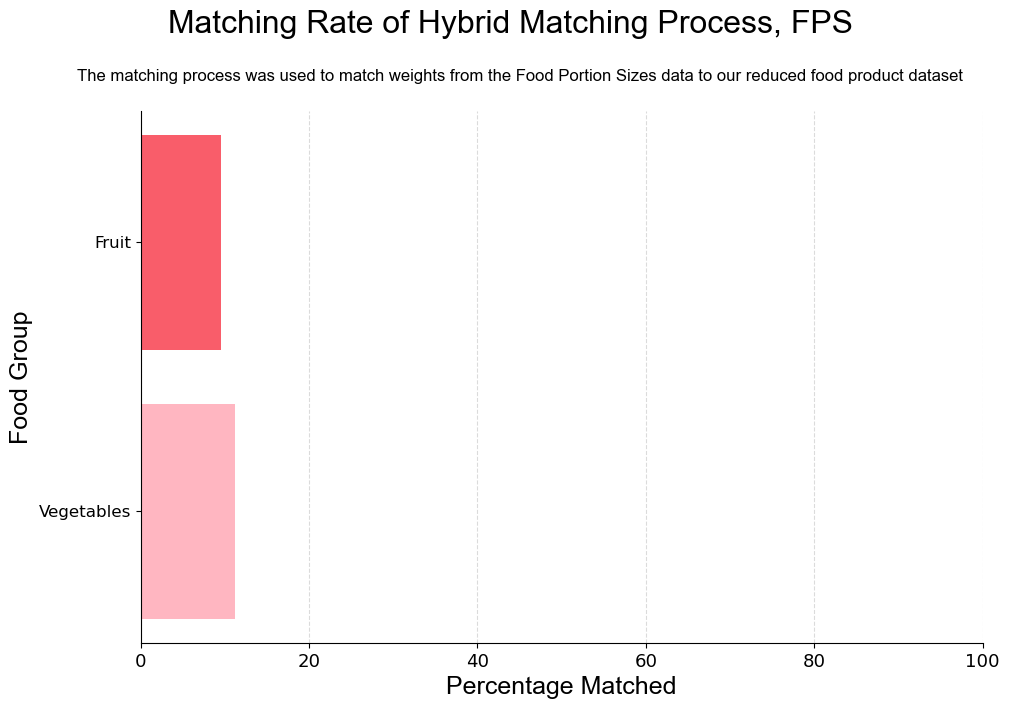

In [39]:
import matplotlib.font_manager as fm

# Find the minimum count in the ax4_counts DataFrame.
min_count4 = ax4_counts['%Matched'].min()

# Create a custom color palette.
bar_colors4 = ['lightpink' if count != min_count4 else '#f95d6a' for count in ax4_counts['%Matched']]

# Set the font family and size for the title.
title_font = fm.FontProperties(family='Arial', size=23)
subtitle_font = fm.FontProperties(family='Arial', size=12)

# Set the font family and size for the axes labels.
axis_font = fm.FontProperties(family='Arial', size=18)

# Create the figure and axes objects.
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the horizontal bar chart.
bars = ax.barh(ax4_counts['Food Group'], ax4_counts['%Matched'], color=bar_colors4)

# Add gridlines to the plot.
ax.grid(axis='x', linestyle='--', alpha=0.45)

# Customize the title, x-axis, and y-axis labels.
plt.suptitle('Matching Rate of Hybrid Matching Process, FPS',ha='center', fontproperties=title_font, y=1)  # Add y parameter
ax.set_title('The matching process was used to match weights from the Food Portion Sizes data to our reduced food product dataset', ha='center', fontproperties=subtitle_font, y=1.04, x=0.45)  # Add y parameter for subtitle
ax.set_xlabel('Percentage Matched', fontproperties=axis_font)
ax.set_ylabel('Food Group', fontproperties=axis_font)

# Set the maximum value of the x-axis to 100.
ax.set_xlim(0, 100)

# Adjust the spacing around the plot.
plt.tight_layout(pad=1.07)

# Remove the top and right spines from the plot.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase the tick label font size.
ax.tick_params(axis='x', which='major', labelsize=13)

# Adjust y-axis tick label alignment and font size.
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right",  fontsize=12)

# Invert the y-axis to display the lowest match on top.
ax.invert_yaxis()

    # Show the plot.
plt.show()


                                                       Next Notebook